# Network architectures

Questo notebook contiene le implementazioni in pytorch delle principali DNN.

- AlexNet
- VGG
- GoogleNet
- ResNet

## AlexNet

In [21]:
import torch
import torch.nn as nn
from torch.nn import functional as F


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def test(net,img_size=32):
    x = torch.randn(1,3,img_size,img_size)
    y = net(x)
    print("Input: {}; Output: {}; N. of params: {:,}".format(list(x.size()), list(y.size()), count_parameters(net)))

In [22]:
class LRN(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=False):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if self.ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1), 
                    stride=1,
                    padding=(int((local_size-1.0)/2), 0, 0)) 
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,
                    padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta
    
    
    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x

In [23]:
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

class AlexNet(nn.Module):
    def __init__(self, num_classes = 1000):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, groups=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, padding=1, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.layer6 = nn.Sequential(
            nn.Linear(in_features=6*6*256, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        self.layer7 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        
        self.layer8 = nn.Linear(in_features=4096, out_features=num_classes)
        
    def forward(self, x):
        x = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        
        print(x.size())
        x = x.view(-1, 6*6*256)
        x = self.layer8(self.layer7(self.layer6(x)))
        
        return x

In [77]:
net = AlexNet()

test(net,227)


torch.Size([1, 256, 6, 6])
Input: [1, 3, 227, 227]; Output: [1, 1000]; N. of params: 62,071,144


In [25]:
net 

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LRN(
      (average): AvgPool3d(kernel_size=(5, 1, 1), stride=1, padding=(2, 0, 0))
    )
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LRN(
      (average): AvgPool3d(kernel_size=(5, 1, 1), stride=1, padding=(2, 0, 0))
    )
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (layer5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


## VGG

In [26]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [27]:
vgg16 = VGG(make_layers(cfg['D']))

test(vgg16,224)

Input: [1, 3, 224, 224]; Output: [1, 1000]; N. of params: 138,357,544


In [28]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## GoogleNet

In [29]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

In [30]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers =  nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(True),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(64, 192, kernel_size=1, stride=1),
            nn.ReLU(True),
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(3,stride=2, padding=1)
        )
        
        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.linear = nn.Linear(1024, 10)
        
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = self.dropout(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [31]:
net = GoogLeNet()

test(net,224)

Input: [1, 3, 224, 224]; Output: [1, 10]; N. of params: 5,832,378


## ResNet

In [32]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, bn_channels, stride=1, bottleneck=False):
        super(ResidualBlock, self).__init__()

        if bottleneck:
            self.expansion = 4
        else:
            self.expansion = 1

        out_channels = bn_channels * self.expansion

        if bottleneck:
                self.block = nn.Sequential(
                nn.Conv2d(in_channels, bn_channels, kernel_size=1, padding=0, bias=False),
                nn.BatchNorm2d(bn_channels),
                nn.ReLU(True),
                nn.Conv2d(bn_channels, bn_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(bn_channels),
                nn.ReLU(True),
                nn.Conv2d(bn_channels, out_channels, kernel_size=1, padding=0, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, bn_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(bn_channels),
                nn.ReLU(True),
                nn.Conv2d(bn_channels, out_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        out = self.block(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [33]:
class ResNet(nn.Module):
    def __init__(self, layers, bottleneck=False):
        super(ResNet, self).__init__()

        self.in_channels = 64
        self.bottleneck = bottleneck

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(64, layers[0])
        self.conv3_x = self._make_layer(128, layers[1], stride=2)
        self.conv4_x = self._make_layer(256, layers[2], stride=2)
        self.conv5_x = self._make_layer(512, layers[3], stride=2)

        self.avgpool = nn.AvgPool2d((1, 1))
        self.fc = nn.Linear(self.in_channels*7*7, 10)

    def _make_layer(self, out_channels, blocks, stride=1):
        layers = []
        for index in range(blocks):
            if index == 0:
                block = ResidualBlock(self.in_channels, out_channels, stride, bottleneck=self.bottleneck)
            else:
                block = ResidualBlock(self.in_channels, out_channels, stride=1, bottleneck=self.bottleneck)
            layers.append(block)
            self.in_channels = out_channels*block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)

        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [34]:

x = torch.randn(1,3,224,224)

net = ResNet([3,4,6,3],bottleneck = False)

y = net(x)

test(net,224)

Input: [1, 3, 224, 224]; Output: [1, 10]; N. of params: 21,535,626


In [35]:
net

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_x): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64

# Train on dataset

Utilizziamo un dataset di immagini, Caltech101, che contiene immagini suddivise in 101 categorie.

Download link: <http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz> (~130MB)

Il task è quello dei riconoscere i soggetti presenti nell'immagine. Train, validation e test sono costruiti utilizzando il 50%, il 25% e il 25% delle immagini presenti nel dataset

In [100]:
# PyTorch
import torch
from torchvision import transforms, datasets, models
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

DATASET_DIR = 'image/101_ObjectCategories'
DATASET_PREPROCESSED = 'image/dataset'

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Run on GPU')
else:
    device = torch.device("cpu")

Run on GPU


## Data Exploration

La distribuzione delle immagini per classe non è bilanciata, sarebbe opportuno considerare lo stesso numero di esempi. 

Total classes 102 with total images 9145, min = 31, max = 800


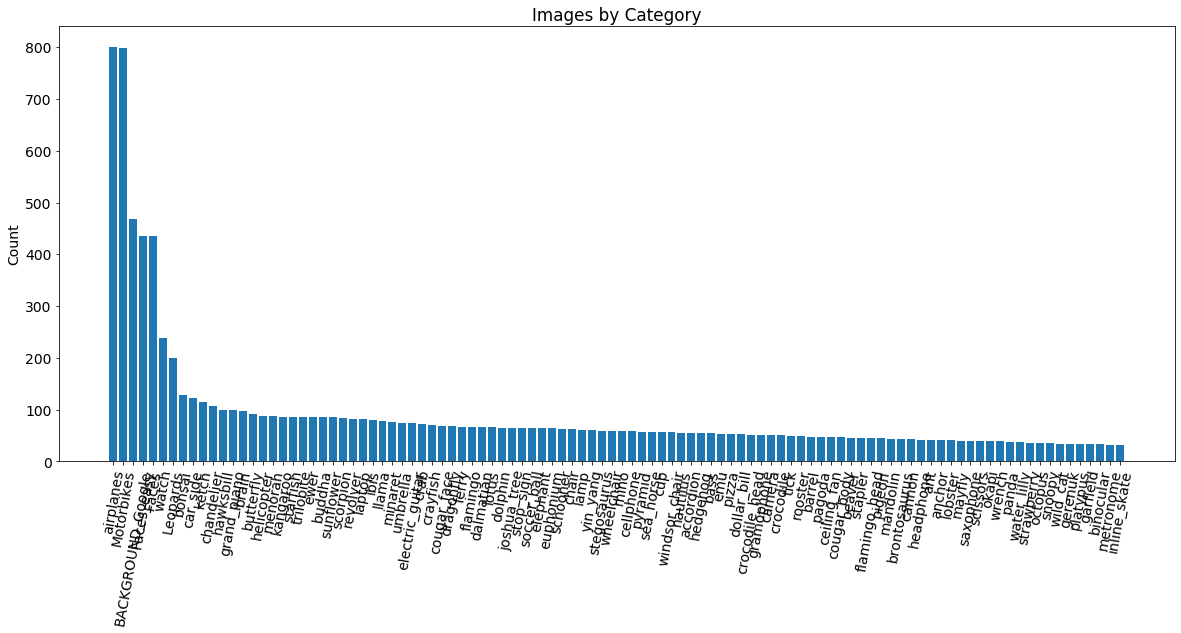

In [37]:
categories = {}

for folder in os.listdir(DATASET_DIR):
    categories[folder] = os.listdir(os.path.join(DATASET_DIR, folder))
    
cnt = [len(x) for x in categories.values()]
minNumberOfImages = min(cnt)
print(f'Total classes {len(categories)} with total images {sum(cnt)}, min = {minNumberOfImages}, max = {max(cnt)}')

items = sorted([(key, len(categories[key])) for key in categories], key=lambda c: -c[1])

x = [k for k, v in items]
y = [v for k, v in items]

fig = plt.figure(figsize=(20, 8))
plt.bar(x, y)
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Images by Category');

### Costruzione di training, validation and test set

Selezioniamo **random** un numero di immagini pari a *minNumberOfImages* per ogni classe e suddividiamo in proporzione 50/25/25 %

In [56]:
import shutil

train_images = []
valid_images = []
test_images = []

i = minNumberOfImages // 2
j = i + minNumberOfImages // 4

for k, v in categories.items():
    
    sample = np.random.choice(v, minNumberOfImages, replace=False)
    
    train_images.extend([os.path.join(k, x) for x in sample[:i]])
    valid_images.extend([os.path.join(k, x) for x in sample[i:j]])
    test_images.extend([os.path.join(k, x) for x in sample[j:]])
    
# build new dataset
if os.path.exists(DATASET_PREPROCESSED):
    shutil.rmtree(DATASET_PREPROCESSED)
    
os.mkdir(DATASET_PREPROCESSED)

for dname, sourceImages in zip(('train', 'valid', 'test'), (train_images, valid_images, test_images)):
    
    dst_directory = os.path.join(DATASET_PREPROCESSED, dname)
    os.mkdir(dst_directory)
    
    for fname in sourceImages:
        fsrc = os.path.join(DATASET_DIR, fname)
        fdst = os.path.join(dst_directory, fname)
        
        if not os.path.exists(os.path.dirname(fdst)):
            os.mkdir(os.path.dirname(fdst))
        os.symlink(os.path.abspath(fsrc), os.path.abspath(fdst))
        
traindir = os.path.join(DATASET_PREPROCESSED, 'train')
validdir = os.path.join(DATASET_PREPROCESSED, 'valid')
testdir = os.path.join(DATASET_PREPROCESSED, 'test')

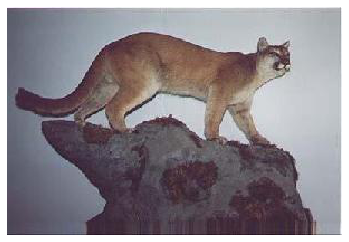

In [49]:
# Example image
image = Image.open(fdst)

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.show();

# Image Preprocessing

Le immagini devono avere una stessa risoluzione, per VGG 224x224, quindi il primo step è effettuare una normalizzazion delle dimensioni. Poi è necessario anche normalizzare i canali colore (sottraedo un valore medio e dividendo per la deviazione standard) per avere una minore distorsione tra gli esempi.

## Data Augmentation

A causa del numero limitato di immagini nel dataset è utile utilizzare delle tecniche di data augmentation per aggiungere versioni alternative delle immagini presenti

In [87]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        #transforms.CenterCrop(size=227),  # fix AlexNet
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Example

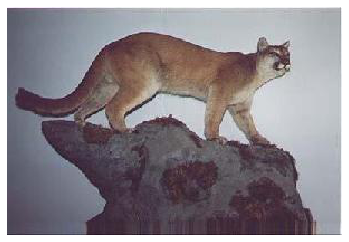

In [88]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.show();

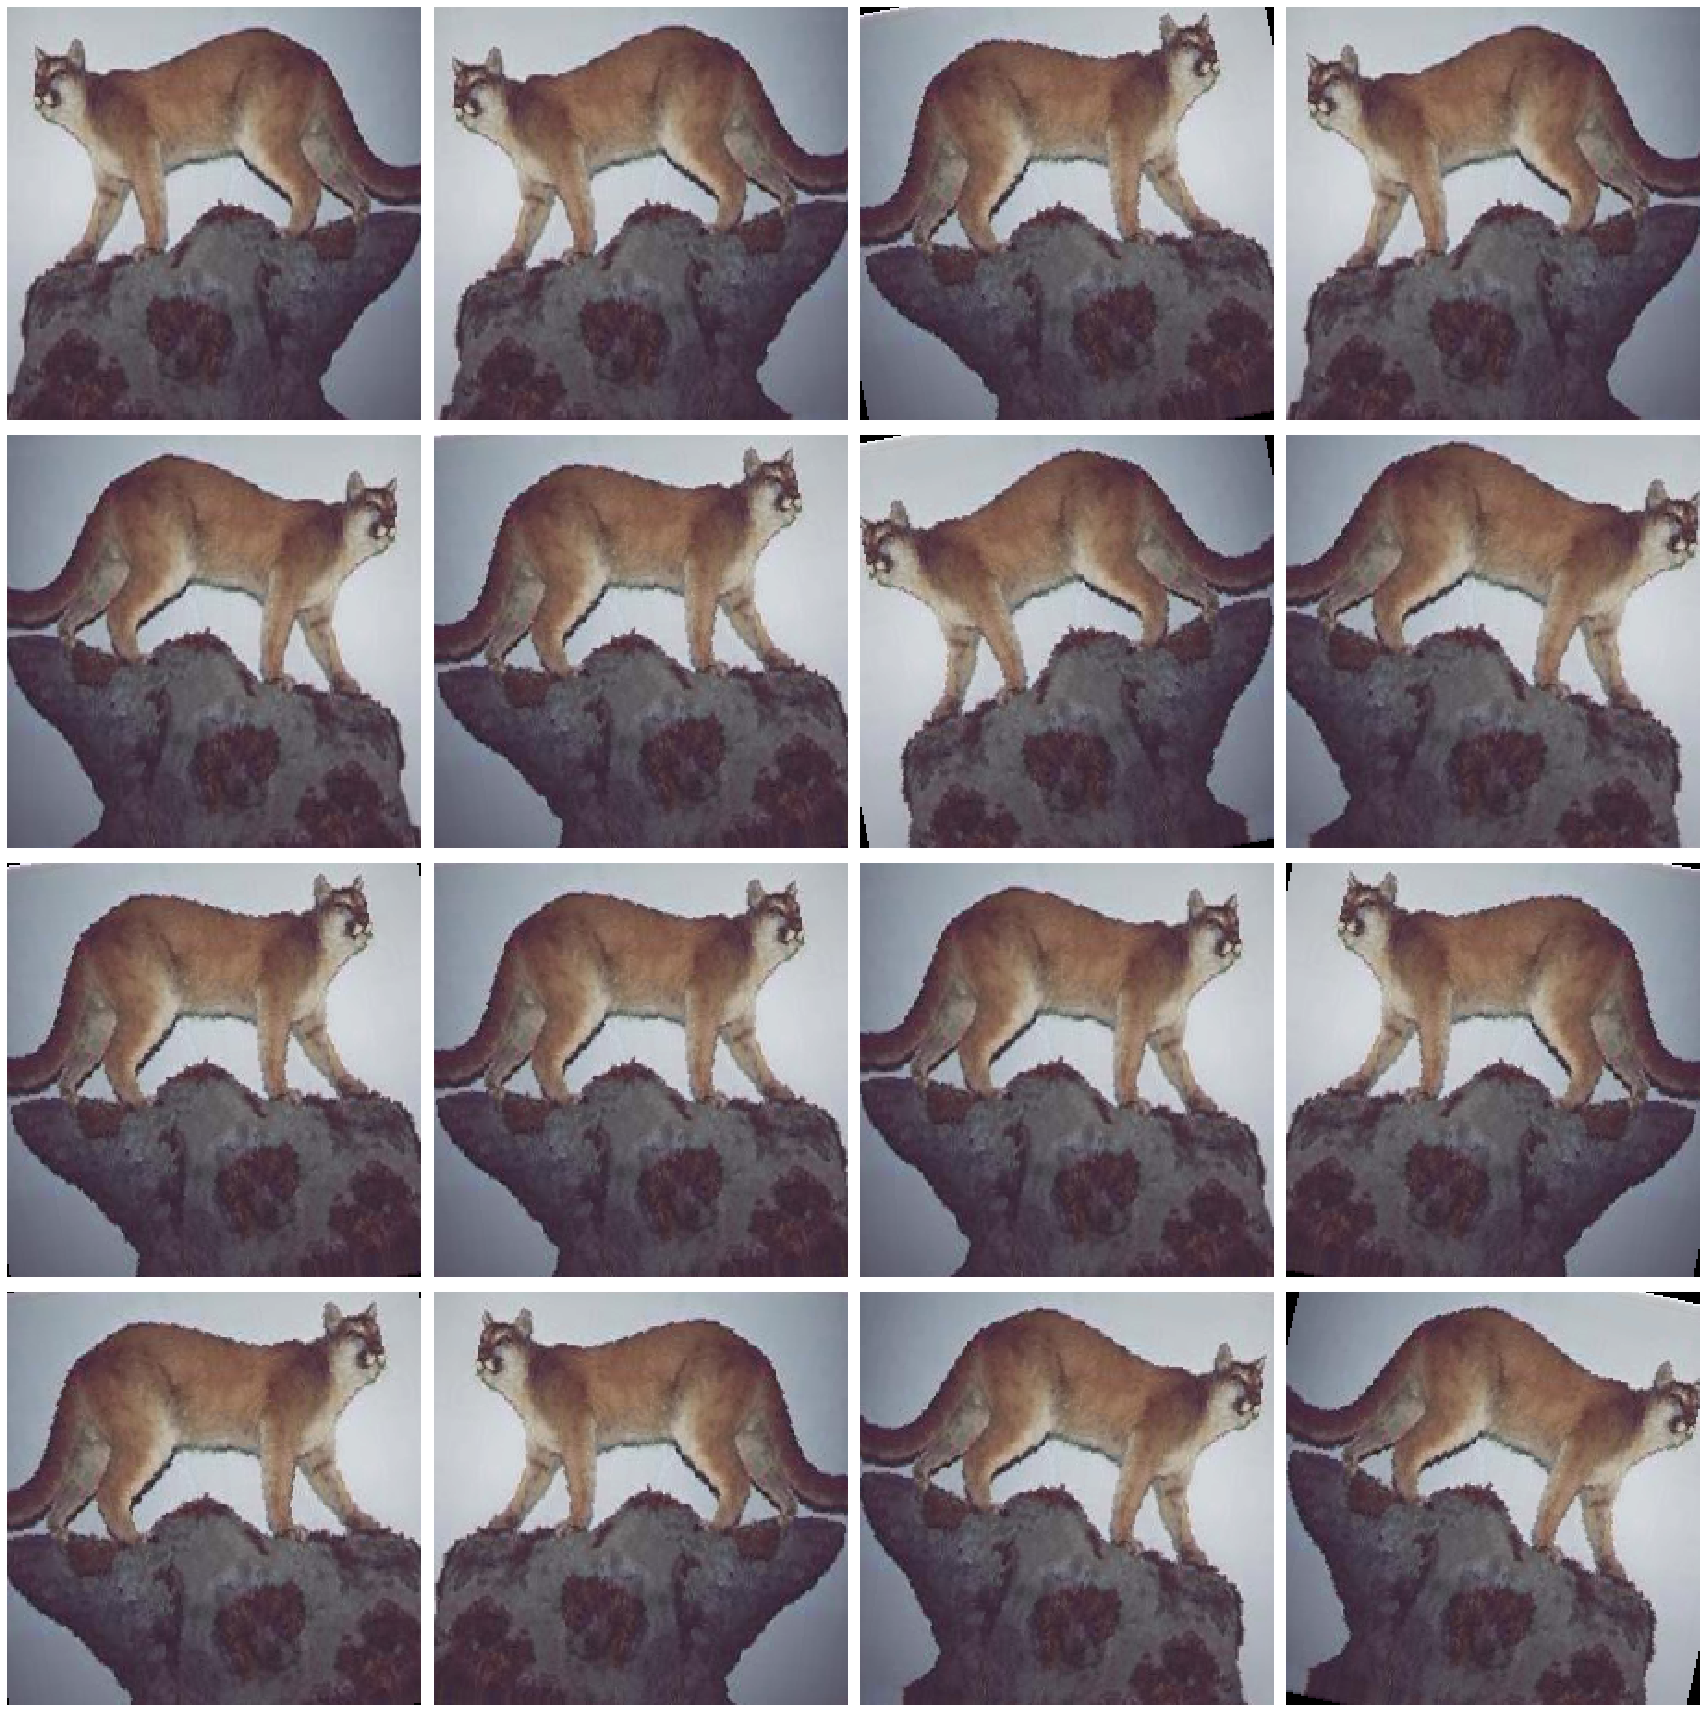

In [89]:
t = image_transforms['train']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(image), ax=ax)

plt.tight_layout();

# Load DATASETS

In [90]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
batch_size = 16
trainloader = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
validloader = DataLoader(data['val'], batch_size=batch_size, shuffle=True)
testloader = DataLoader(data['test'], batch_size=batch_size, shuffle=True)


In [122]:
print(trainloader.dataset.classes)

['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 's

Tramite i loader possiamo iterare sul dataset: 

In [91]:
trainiter = iter(trainloader)
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

The shape of a batch is (batch_size, color_channels, height, width).

In [92]:
n_classes = len(categories)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)

There are 102 different classes.


102

# Train an VGG16 classifier

In [174]:
vgg16 = VGG(make_layers(cfg['D']), num_classes=n_classes)

test(vgg16, 224)

model = vgg16.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

Input: [1, 3, 224, 224]; Output: [1, 102]; N. of params: 134,678,438


In [175]:
epochs = 100
steps = 0
running_loss = 0
print_every = 20

train_losses, test_losses = [], []

try:
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)

            if epoch == 0 and steps == 1:
                print(f'input shape is {inputs.shape}, labels are {labels.shape}')

            optimizer.zero_grad()
            logps = model.forward(inputs)

            loss = criterion(logps, labels)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()

            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0
                model.eval()

                with torch.no_grad():
                    for inputs, labels in validloader:
                        inputs, labels = inputs.to(device), labels.to(device)

                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)

                        test_loss += batch_loss.item()

                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(validloader))                    

                print(f"Epoch {epoch+1}/{epochs}... "
                      f"Train loss: {running_loss/print_every:.3f}... "
                      f"Valid loss: {test_loss/len(testloader):.3f}... "
                      f"Valid accuracy: {accuracy/len(testloader):.3f}")

                running_loss = 0

                model.train()
except KeyboardInterrupt: 
    print('Exiting from training early')

# torch.save(model, 'vgg16model.pth')

input shape is torch.Size([16, 3, 224, 224]), labels are torch.Size([16])
Epoch 1/100... Train loss: -1076373544226469548392448.000... Valid loss: -15869779129086489745424384.000... Valid accuracy: 0.008
Epoch 1/100... Train loss: -44117097773699124518977536.000... Valid loss: -61908395977402914684534784.000... Valid accuracy: 0.008
Epoch 1/100... Train loss: -101849982689899445986787328.000... Valid loss: -107632875309461254046744576.000... Valid accuracy: 0.008
Epoch 1/100... Train loss: -150305925993870643341295616.000... Valid loss: -149567886123317633084293120.000... Valid accuracy: 0.008
Epoch 2/100... Train loss: -206913589266949506171142144.000... Valid loss: -190764503986398029961756672.000... Valid accuracy: 0.008
Epoch 2/100... Train loss: -275957362559149595053522944.000... Valid loss: -232215077061975582548426752.000... Valid accuracy: 0.008
Epoch 2/100... Train loss: -311084935595357629124182016.000... Valid loss: -271433607780668696636162048.000... Valid accuracy: 0.008


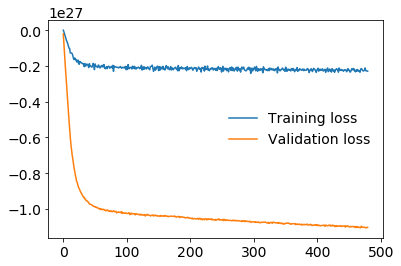

In [176]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show();

# Analisi dei risultati

Valutazione del modello sul test set

In [177]:
def predict_on_image(img_tensor, real_class, classes_list, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        img_tensor (tensor): tensor of the image
        classes_list list(str): list of category 
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            classes_list[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class
    
    
def display_prediction(dataloader, idx, model, topk):
    """Display image and preditions from model"""
    img_tensor, idx_class = dataloader.dataset[idx]
    img_tensor = img_tensor.to(device)
    
    real_class = dataloader.dataset.classes[idx_class]

    # Get predictions
    img, ps, classes, y_obs = predict_on_image(img_tensor, real_class, dataloader.dataset.classes, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    #ax.imshow(img.numpy().transpose(1, 2, 0), cmap=)
    imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()
    
    
def compute_accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    output = output.to(device)
    target = target.to(device)

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

    
def evaluate(model, test_loader, criterion, topk=(1, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """
    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            data, targets = data.to(device), targets.to(device)

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = compute_accuracy(pred.unsqueeze(0), true.unsqueeze(0), topk)
                
                #classes.append(model.idx_to_class[true.item()])
                classes.append(test_loader.dataset.classes[true.item()])
                
                # Calculate the loss
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})

In [178]:
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results = evaluate(model, testloader, criterion)
results.head()

,class,top1,top5,loss
0,BACKGROUND_Google,0.0,0.0,-1.982368e+27
1,Faces,0.0,0.0,-5.248622e+26
2,Faces_easy,0.0,0.0,-9.208511e+26
3,Leopards,0.0,0.0,-3.987136e+26
4,Motorbikes,0.0,0.0,-2.154838e+27


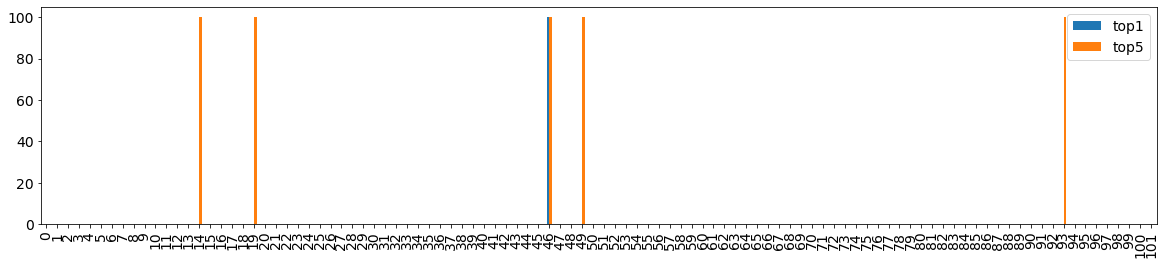

In [179]:
results[['top1', 'top5']].plot.bar(figsize=(20, 4));

Applichiamo il modello sulle singole immagini

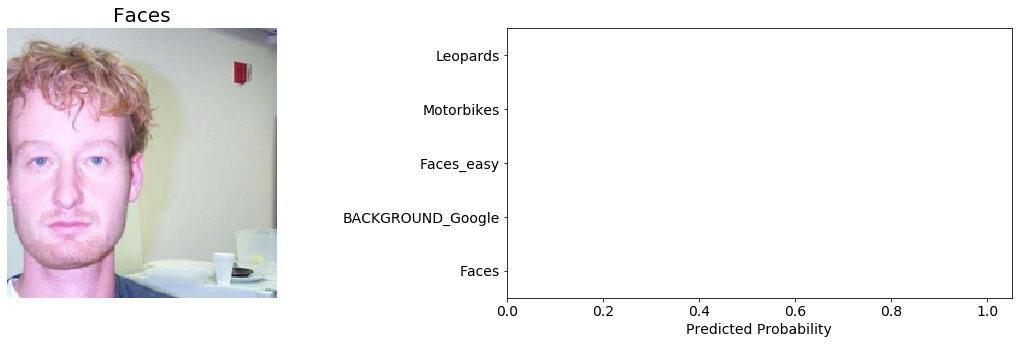

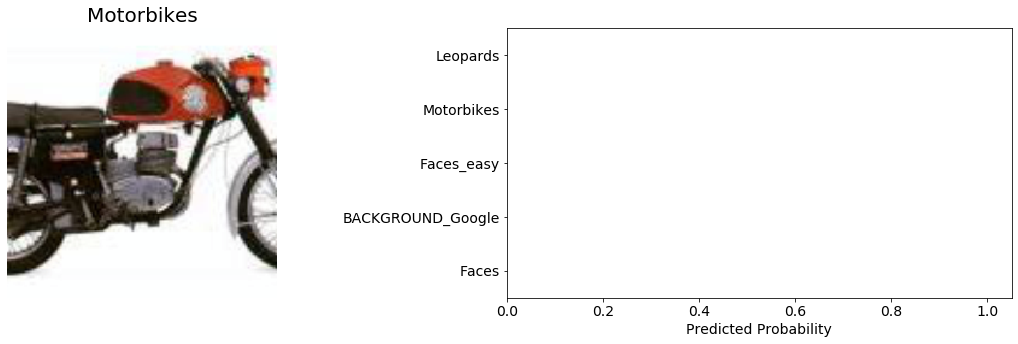

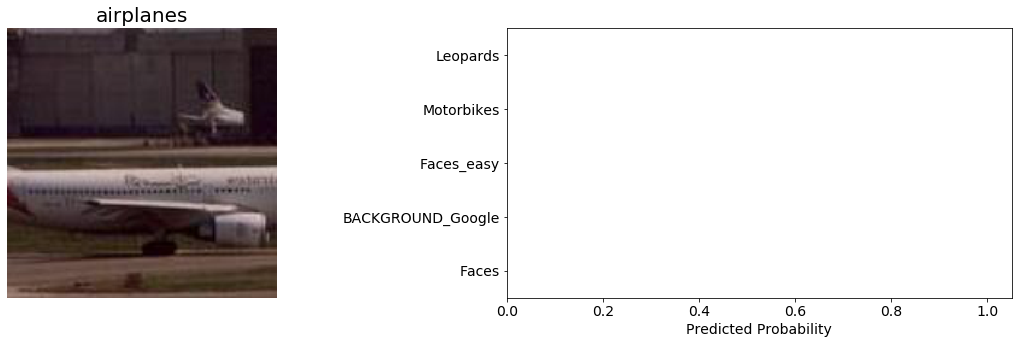

In [180]:
display_prediction(testloader, 13, model, 5)
display_prediction(testloader, 43, model, 5)
display_prediction(testloader, 53, model, 5)

# Transfer Learning

Invece di addestrare il modello sul dataset, si può utilizzare un modello pre-addestrato su un dataset simile.

In questo caso utilizziamo un modello VGG16 addestrato si ImageNet, sun dataset contenente più di un milione di immagini ed utilizzato per identificare 1000 categorie diverse.

## Strategia

Per utilizzare un modello pre-addestrato si segue questo protocollo:

- Si carica il modello pre-addestrato
- Si mantengono fissi i pesi dei layer convoluzionali
- Si sostituiscono i layer fully connected e si procede con l'addestramento sul dataset di interesse



In [181]:
from torchvision import models

modelPreTrained = models.vgg16(pretrained=True, progress=False)
modelPreTrained

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Freeze layer

Per impedire l'aggiornamento dei pesi del modello escludiamo i relativi tensori dal grafo di computazione

In [182]:
# Freeze layers
for param in modelPreTrained.parameters():
    param.requires_grad = False

Quanti sono i parametri del modello?

In [183]:
test(modelPreTrained, 224)

Input: [1, 3, 224, 224]; Output: [1, 1000]; N. of params: 0


### Nuovi layer fully connected

Aggiungiamo il layer che effettueranno la classificazione.
Nel modello caricato, i layer di classificazione sono memorizzati nella variabile **classifier**. Quindi sostituiamo l'ultimo livello con una nuova versione.

- La dimensione dell'input deve essere uguale all'output del layer precedente
- La dimensione dell'output (ultimo levello) deve essere pari al numero di classi (102 per il dataset utilizzato in questo notebook)

Il nuovo classifier sarà composto da:

1. Fully connected with ReLU activation (n_inputs, 256)
2. Dropout with 40% chance of dropping
3. Fully connected with log softmax output (256, n_classes)

I nuovi layer DEVONO avere l'attributo require_grad=True (default) così da poter essere aggiornati in fase di addestramento

In [184]:
n_inputs = modelPreTrained.classifier[6].in_features
n_classes = len(trainloader.dataset.classes)

# Add on classifier
modelPreTrained.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), 
    nn.ReLU(), 
    nn.Dropout(0.4),
    nn.Linear(256, n_classes), 
    nn.LogSoftmax(dim=1)
)

modelPreTrained.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=102, bias=True)
    (4): LogSoftmax()
  )
)

Adesso quanti sono i parametri del modelli che possono essere addestrati?

In [185]:
test(modelPreTrained, 224)

Input: [1, 3, 224, 224]; Output: [1, 102]; N. of params: 1,075,046


## Train the model

In [186]:
modelPreTrained = modelPreTrained.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(modelPreTrained.parameters())

In [187]:
epochs = 10
steps = 0
running_loss = 0
print_every = 20

train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        if epoch == 0 and steps == 1:
            print(f'input shape is {inputs.shape}, labels are {labels.shape}')
        
        optimizer.zero_grad()
        logps = modelPreTrained.forward(inputs)
        
        loss = criterion(logps, labels)
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            modelPreTrained.eval()
            
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    logps = modelPreTrained.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(validloader))                    
            
            print(f"Epoch {epoch+1}/{epochs}... "
                  f"Train loss: {running_loss/print_every:.3f}... "
                  f"Valid loss: {test_loss/len(testloader):.3f}... "
                  f"Valid accuracy: {accuracy/len(testloader):.3f}")
            
            running_loss = 0
            
            modelPreTrained.train()
            
# torch.save(modelPreTrained, 'vgg16-pretrained-model.pth')

input shape is torch.Size([16, 3, 224, 224]), labels are torch.Size([16])
Epoch 1/10... Train loss: 4.572... Valid loss: 3.221... Valid accuracy: 0.165
Epoch 1/10... Train loss: 4.195... Valid loss: 2.703... Valid accuracy: 0.269
Epoch 1/10... Train loss: 3.557... Valid loss: 2.076... Valid accuracy: 0.359
Epoch 1/10... Train loss: 2.992... Valid loss: 1.535... Valid accuracy: 0.464
Epoch 2/10... Train loss: 2.421... Valid loss: 1.242... Valid accuracy: 0.506
Epoch 2/10... Train loss: 1.809... Valid loss: 1.019... Valid accuracy: 0.516
Epoch 2/10... Train loss: 1.655... Valid loss: 0.930... Valid accuracy: 0.551
Epoch 2/10... Train loss: 1.550... Valid loss: 0.869... Valid accuracy: 0.564
Epoch 2/10... Train loss: 1.451... Valid loss: 0.818... Valid accuracy: 0.563
Epoch 3/10... Train loss: 1.390... Valid loss: 0.795... Valid accuracy: 0.575
Epoch 3/10... Train loss: 1.083... Valid loss: 0.725... Valid accuracy: 0.584
Epoch 3/10... Train loss: 1.187... Valid loss: 0.739... Valid accura

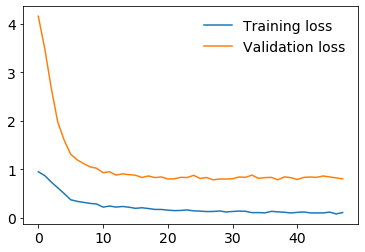

In [188]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show();

# Analisi dei risultati

In [189]:
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results = evaluate(modelPreTrained, testloader, criterion)
results.head()

,class,top1,top5,loss
0,BACKGROUND_Google,50.000000,75.000000,2.561424
1,Faces,22.222222,100.000000,1.169563
2,Faces_easy,77.777778,100.000000,0.849270
3,Leopards,66.666667,88.888889,0.875035
4,Motorbikes,100.000000,100.000000,0.010580


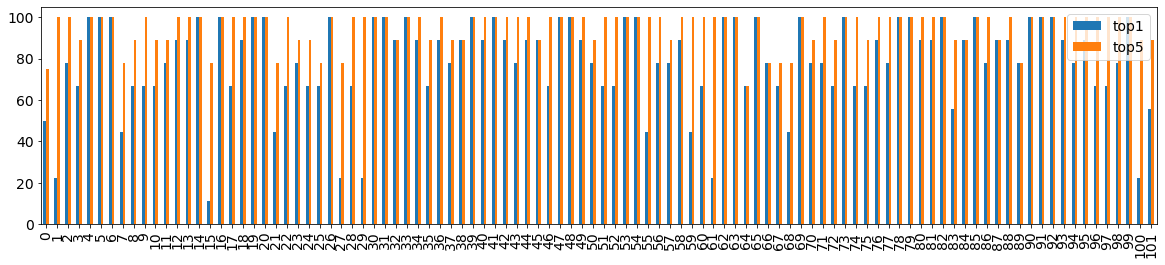

In [190]:
results[['top1', 'top5']].plot.bar(figsize=(20, 4));

Valutazione sulle immagini

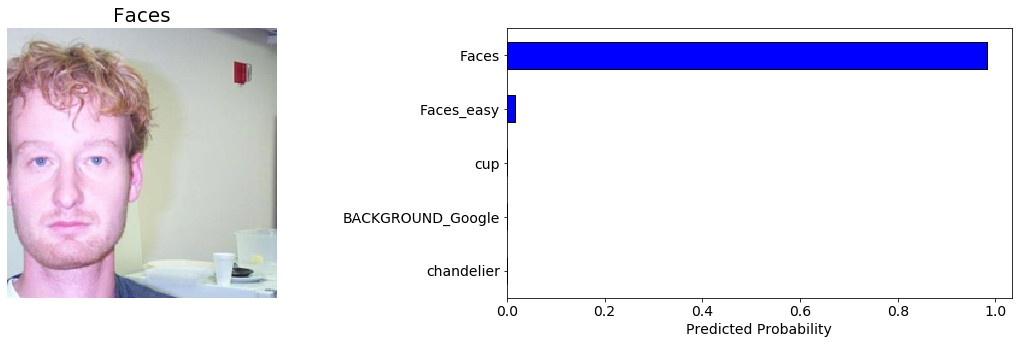

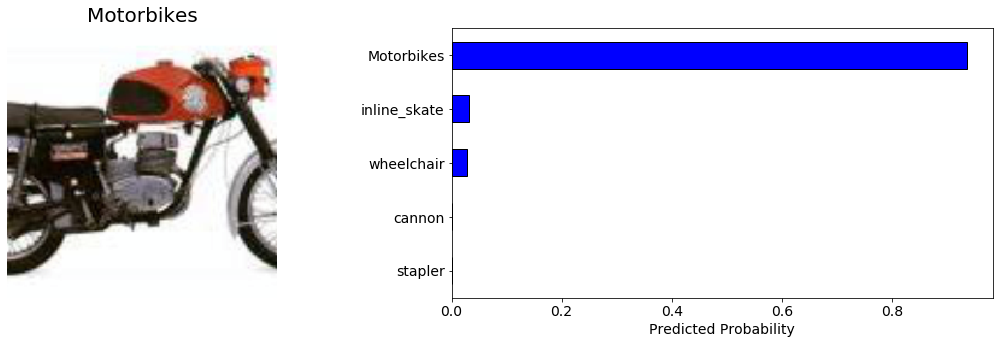

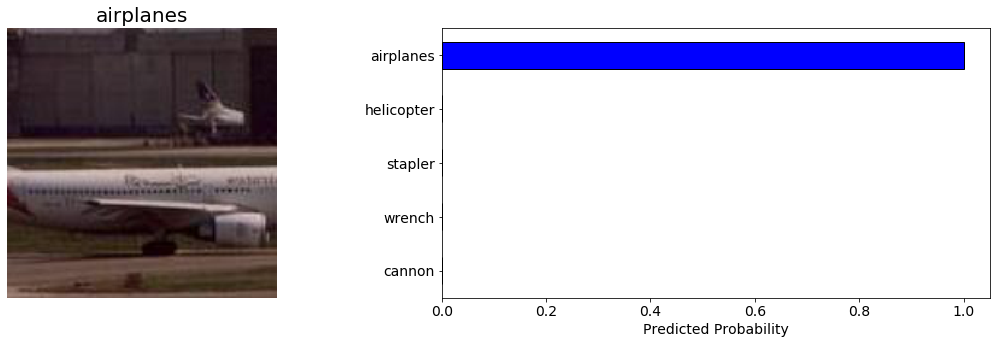

In [191]:
display_prediction(testloader, 13, modelPreTrained, 5)
display_prediction(testloader, 43, modelPreTrained, 5)
display_prediction(testloader, 53, modelPreTrained, 5)

# Bonus: activation map

L'output e i weight associati ad ogni livello possono essere visualizzati in forma grafica per "comprendere" cosa la rete sta apprendendo. Ovviamente maggiore è la profondità minore è la possibilità di comprendere cosa sta accadendo e quali feature sono state estratte.
Attenzione: ogni layer ha un certo numero di filtri (es. 64) quindi volendo visualizzarli in termini di feature estratte dall'immagine, è possibile visualizzare l'effetto del singolo filtro.

Il pacchetto è può essere installato con il comando

    pip install git+https://github.com/andrijdavid/viztools-pytorch.git
    

In [222]:
# bug fix

from collections import OrderedDict
from viztools.util import (
    defuse_model,
    assert_numpy_image,
    insert_flatten_layer,
    normalize_image,
    convert_image_tensor,
    combine_images
)


def viz_act_val(image, model, layer, kernel):
    """
    Record activation values of each layer and return them as OrderedDict
    Args:
        image            : (np.ndarray) input image
        model            : (nn.Module) PyTorch pretrained model
        layer            : (str) target layer
        kernel           : (int) target kernel
    Returns:
        activation_value : (np.ndarray) activation value in array
    """
    assert_numpy_image(image)
    assert isinstance(model, nn.Module), "'module' is not nn.Module"
    layers = defuse_model(model)
    assert layer in layers.keys(), f"'{layer}' not in 'model'"
    # insert Flatten layer if needed
    if "Linear-1" in layers.keys(): layers = insert_flatten_layer(layers)
    # preprocess image
    image = convert_image_tensor(normalize_image(image))

    if torch.cuda.is_available():
        for tag in layers.keys(): layers[tag] = layers[tag].cuda()
        image = image.cuda()
    
    for tag, module in layers.items():
        image = module(image)
        if tag == layer:
            assert kernel < image.size()[1], "'kernel' out of bound"
            activation = image[0, kernel].cpu().data.numpy()
            activation -= activation.min()
            activation /= activation.max()
            return activation


In [204]:
modelPreTrained

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

activation shape (224, 224)


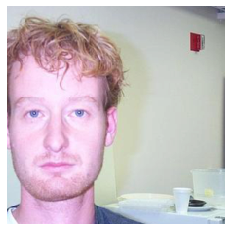

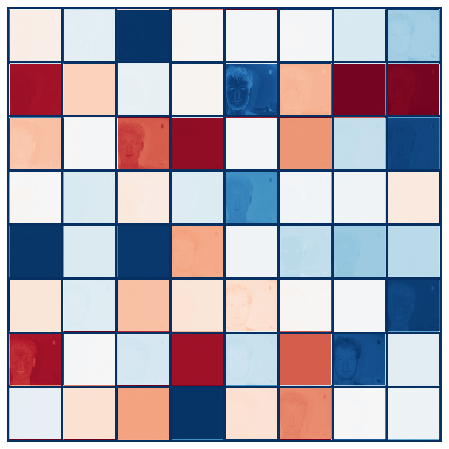

In [240]:
image, _ = testloader.dataset[13]

imshow_tensor(image)

image_array = image.cpu().numpy().transpose(1, 2, 0)

# layer indexing convention: '<nn.Module>-i>' ('Conv2d-1' means 1st Conv2d layer)
result = []
layer_name = 'Conv2d-1'
filters = 64

for layerID in range(filters):
    activation_value = viz_act_val(image_array, modelPreTrained, layer_name, layerID)
    result.append(activation_value)

print(f'activation shape {activation_value.shape}')

result_image = combine_images(result)

fig = plt.figure(figsize=(8, 8))
plt.imshow(result_image, cmap=plt.cm.RdBu_r)
plt.axis('off')
plt.show();

/home/pisani/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


activation shape (224, 224)


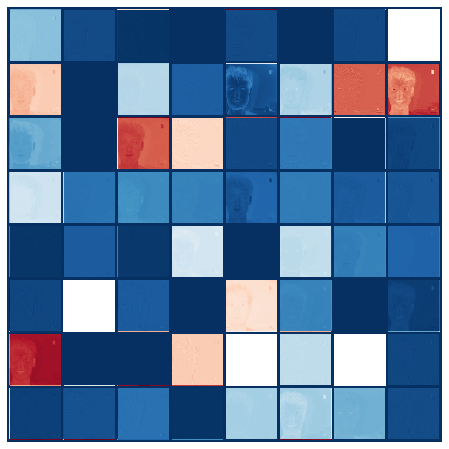

In [241]:
# layer indexing convention: '<nn.Module>-i>' ('Conv2d-1' means 1st Conv2d layer)
result = []
layer_name = 'ReLU-1'
filters = 64

for layerID in range(filters):
    activation_value = viz_act_val(image_array, modelPreTrained, layer_name, layerID)
    result.append(activation_value)

print(f'activation shape {activation_value.shape}')

result_image = combine_images(result)

fig = plt.figure(figsize=(8, 8))
plt.imshow(result_image, cmap=plt.cm.RdBu_r)
plt.axis('off')
plt.show();

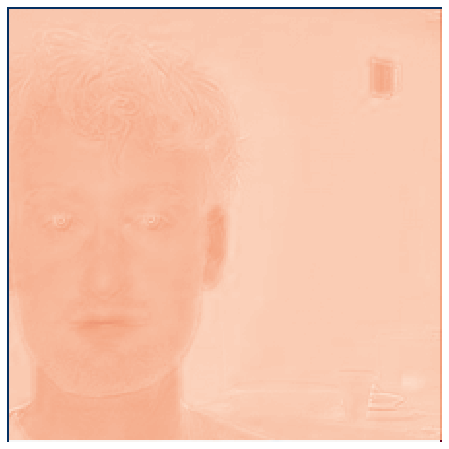

In [243]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(result[8], cmap=plt.cm.RdBu_r)
plt.axis('off')
plt.show();